In [1]:
from copy import deepcopy
import os
import pathlib
import sys

In [2]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import torch

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.solver import QLSMSolver, ClassicSolver
from endure.lsm.types import Policy, System, LSMDesign
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

# Loading Model

In [4]:
path = '/data/models/ltune/qlsm-10-24/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
# config = Reader.read_config('../../endure.toml')
cf = EndureCost(config)
design_type = config['lsm']['design']
design_type

'QLSM'

In [5]:
model = LTuneModelBuilder(config).build_model()
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_21.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
# status

QLSMTuner(
  (in_norm): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (in_layer): Linear(in_features=9, out_features=64, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU(inplace=True)
  )
  (q_decision): Linear(in_features=64, out_features=30, bias=True)
  (t_decision): Linear(in_features=64, out_features=30, bias=True)
  (bits_decision): Linear(in_features=64, out_features=1, bias=True)
)

# Util Module    

In [6]:
ltune_util = LTuneEvalUtil(config, model, design_type)

In [9]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)
out, design
# system

(tensor([[5.7857, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
        grad_fn=<CatBackward0>),
 LSMDesign(h=5.785660743713379, T=30, policy=<Policy.QFixed: 3>, Q=3, Y=1.0, Z=1.0, K=[]))

# Training Loss

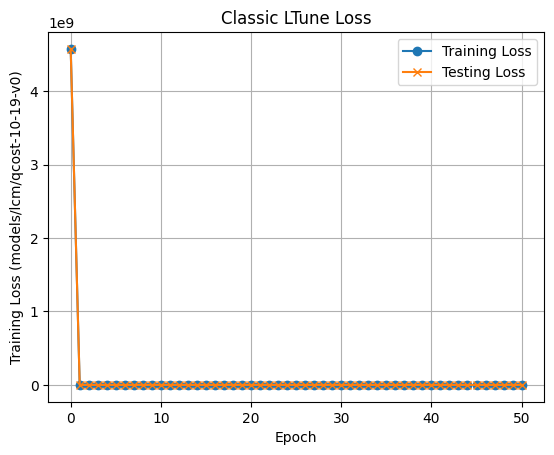

In [10]:
losses = pd.read_csv(os.path.join(path, 'losses.csv')).loc[0:50]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], '-o', label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], '-x', label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LTuneTrain"]["loss_fn_path"]})')
# ax.set_title(f'{path}')
ax.set_title('Classic LTune Loss')
ax.grid()
# ax.set_yscale('log')
_ = ax.legend()

In [11]:
losses.idxmin()

epoch         0
train_loss    2
test_loss     1
dtype: int64

In [12]:
def eval_lcm(design, system, z0, z1, q, w):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    T = design.T - config['lsm']['size_ratio']['min']
    T = np.eye(categories, dtype=np.int32)[int(np.ceil(T))]
    policy = np.eye(2, dtype=np.int32)[design.policy.value]
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), policy, T))
    inputs = torch.from_numpy(inputs).to(torch.float).view(1, -1)
    with torch.no_grad():
        pred = loss_model(inputs)
        pred = pred.sum().item()
    return pred

In [54]:
def eval_lcm_direct(model_out, system, z0, z1, q, w):
    label = torch.Tensor([z0, z1, q, w, system.B, system.s, system.E, system.H, system.N]).view(1, -1)
    inputs = torch.concat([label, model_out], dim=-1)
    with torch.no_grad():
        pred = loss_model(inputs)
        pred = pred.sum().item()
    return pred

# Evaluation

In [13]:
num_samples = 5000
default_sys = System()
table = []
for _ in tqdm(range(num_samples)):
    row = ltune_util.gen_sample_eval()
    table.append(row)

table = pd.DataFrame(table)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
np.random.seed(0)
table['delta_cost'] = (table['stune_cost'] - table['ltune_cost']) / table['stune_cost']
table['delta_loss'] = (table['stune_loss'] - table['ltune_loss']) / table['stune_loss']
table['stune_diff'] = (table['stune_cost'] - table['stune_loss']) / table['stune_cost']
table['ltune_diff'] = (table['ltune_cost'] - table['ltune_loss']) / table['ltune_cost']

In [16]:
cols = ['z0', 'z1', 'q', 'w',
        'stune_policy', 'stune_h', 'stune_T',
        'ltune_policy', 'ltune_h', 'ltune_T',
        'stune_cost', 'stune_loss',
        'ltune_cost', 'ltune_loss', 'ltune_loss_indirect',
        'delta_cost', 'delta_loss',]
        # 'stune_diff', 'ltune_diff']
table.sort_values(by='delta_cost', ascending=True).head(20)[cols]

,z0,z1,q,w,stune_policy,stune_h,stune_T,ltune_policy,ltune_h,ltune_T,stune_cost,stune_loss,ltune_cost,ltune_loss,ltune_loss_indirect,delta_cost,delta_loss
3615,0.845,0.016,0.040,0.099,3,9.079860,7.197292,3,10.395967,2,0.361860,0.400423,1.516002,0.498086,0.377029,-3.189475,-0.243899
4224,0.847,0.052,0.029,0.072,3,7.717951,7.698054,3,7.838863,2,0.312336,0.267071,1.243523,0.430734,0.379970,-2.981365,-0.612808
3646,0.690,0.053,0.039,0.218,3,9.196883,6.793525,3,10.546505,2,0.328395,0.284092,1.194474,0.424881,0.397532,-2.637304,-0.495575
4712,0.702,0.078,0.060,0.160,3,7.557501,6.987385,3,8.816425,2,0.688987,0.689092,2.465407,1.060728,0.889529,-2.578305,-0.539312
684,0.623,0.323,0.040,0.014,3,9.800703,22.429074,3,10.229011,2,0.476981,0.494515,1.680780,0.724070,0.669225,-2.523790,-0.464201
733,0.141,0.104,0.038,0.717,3,6.384198,7.425931,3,6.537369,2,0.316648,0.259048,1.076744,0.432635,0.381242,-2.400439,-0.670098
2470,0.458,0.009,0.055,0.478,3,7.387586,6.231075,3,8.354108,2,0.452885,0.445401,1.510263,0.739607,0.552632,-2.334760,-0.660541
4984,0.605,0.060,0.028,0.307,3,10.360859,6.819510,3,11.711320,2,0.216255,0.201098,0.719444,0.248548,0.239331,-2.326838,-0.235955
2489,0.514,0.439,0.045,0.002,3,9.491505,31.000000,3,9.069355,2,0.614426,0.787279,2.032919,0.997650,0.827093,-2.308648,-0.267213
4493,0.750,0.124,0.034,0.092,3,8.630319,7.052280,3,9.686545,2,0.386941,0.335402,1.253800,0.531048,0.359164,-2.240284,-0.583316


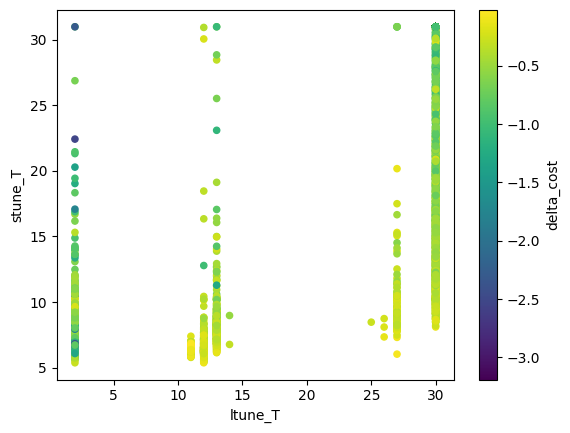

In [18]:
ax = table.plot.scatter(x='ltune_T', y='stune_T', c='delta_cost')

## Analytical Cost Model

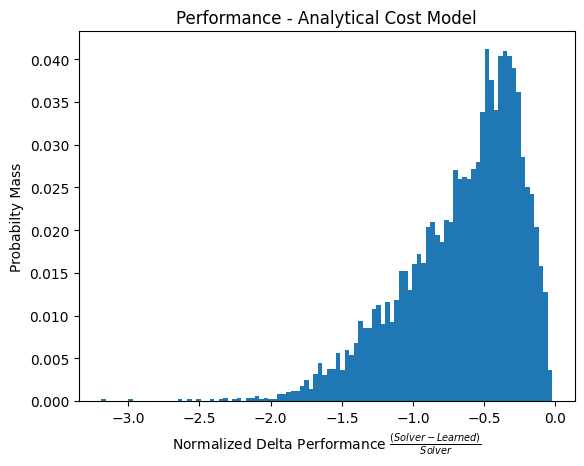

In [19]:
fig, ax = plt.subplots()
data = table['delta_cost']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), alpha=1, density=False, label='ACM', color='tab:blue')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
ax.set_title('Performance - Analytical Cost Model')
# ax.legend()
plt.show()

## Learned Cost Model

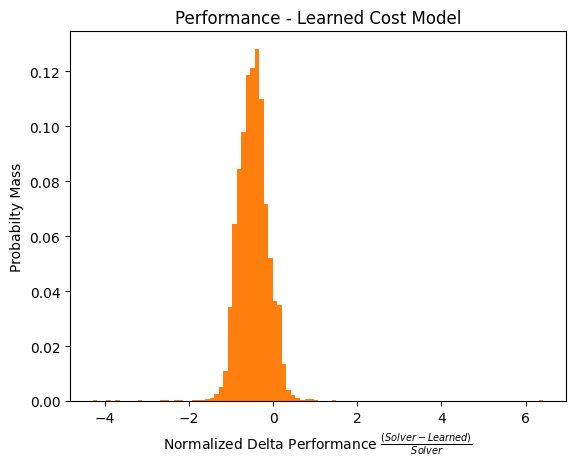

In [20]:
fig, ax = plt.subplots()
data = table['delta_loss']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), density=False, color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
ax.set_title('Performance - Learned Cost Model')
plt.show()

## Difference in ACM and LCM

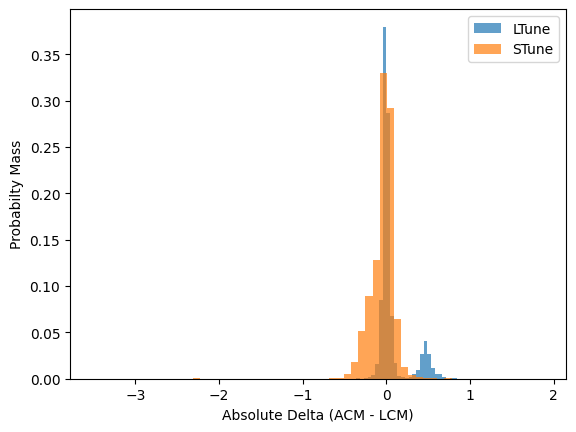

In [21]:
fig, ax = plt.subplots()
ldata = table['ltune_diff']
sdata = table['stune_diff']
ax.hist(ldata, weights=np.ones_like(ldata)/len(ldata), bins=50, alpha=0.7, label='LTune', color='tab:blue')
ax.hist(sdata, weights=np.ones_like(sdata)/len(sdata), bins=50, alpha=0.7, label='STune', color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Absolute Delta (ACM - LCM)')
ax.legend()
plt.show()

In [23]:
table['ltune_mbuff'] = ((table['H'] - table['ltune_h']) * table['N']) / (1 * 1024 * 1024 * 1024 * 8)

## Workload Correlations

In [25]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

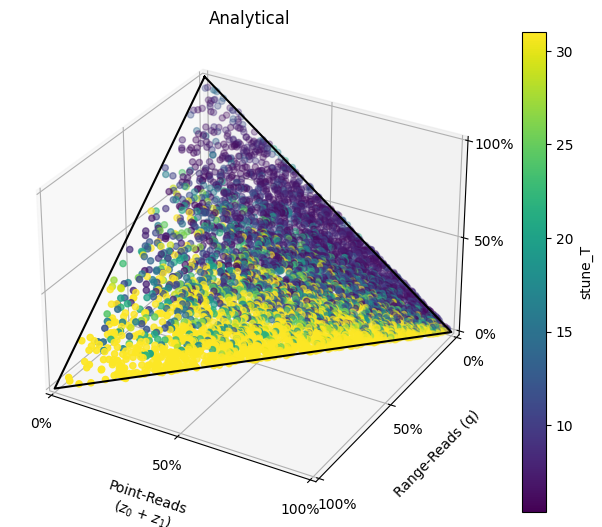

In [26]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_T')
ax.set_title('Analytical')
plt.show()

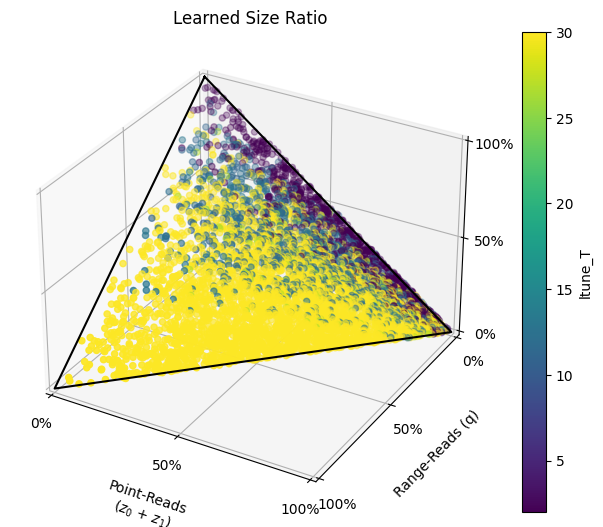

In [27]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_T')
ax.set_title('Learned Size Ratio')
plt.show()

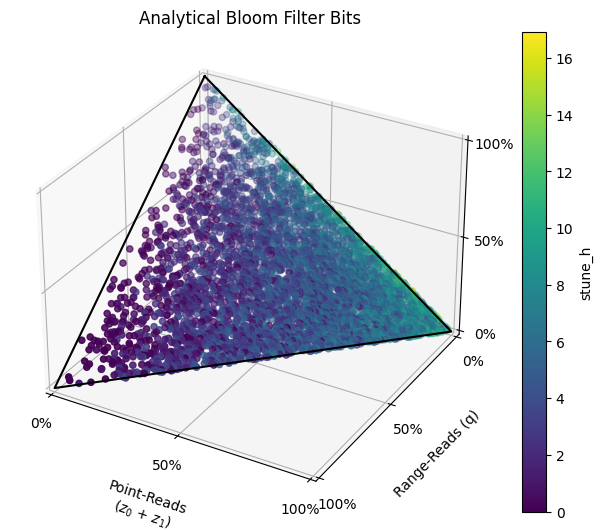

In [28]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_h')
ax.set_title('Analytical Bloom Filter Bits')
plt.show()

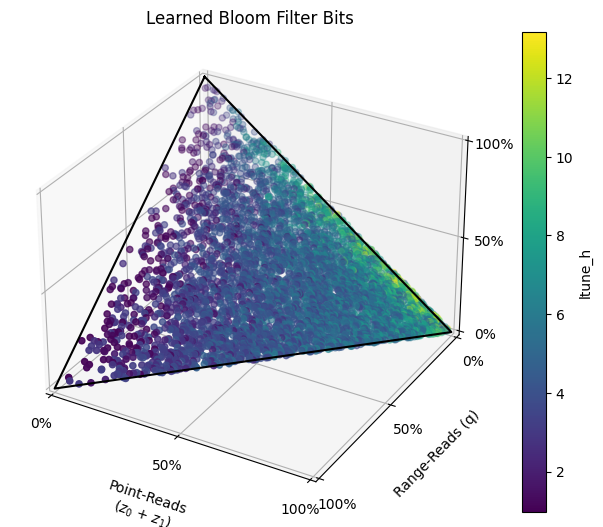

In [29]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_h')
ax.set_title('Learned Bloom Filter Bits')
plt.show()

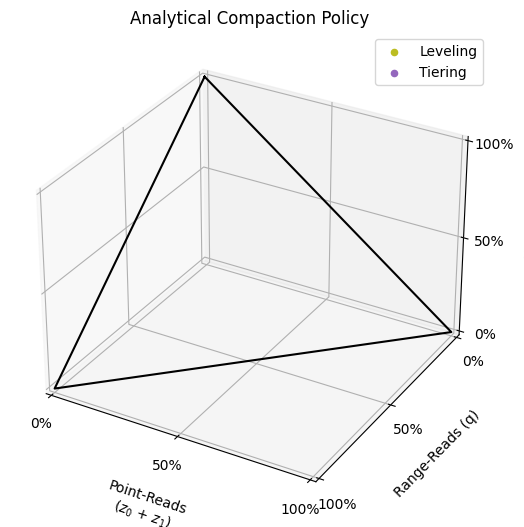

In [30]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

groupa = table[table['stune_policy'] == 1]
groupb = table[table['stune_policy'] == 0]
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='Leveling', color='tab:olive')
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Tiering', color='tab:purple')
ax.set_title('Analytical Compaction Policy')
ax.legend()
plt.show()

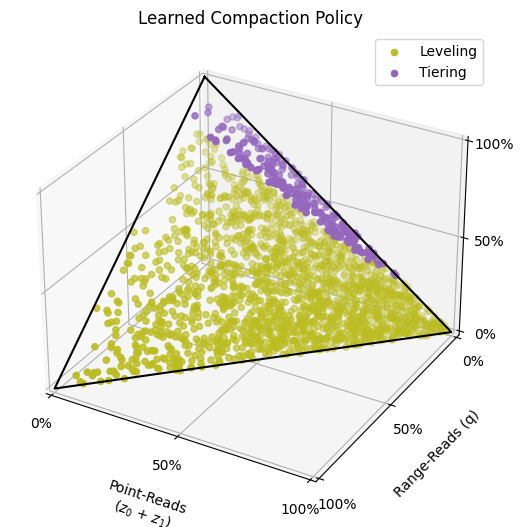

In [30]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

groupa = df[df['ltune_policy'] == 1]
groupb = df[df['ltune_policy'] == 0]
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='Leveling', color='tab:olive')
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Tiering', color='tab:purple')
ax.set_title('Learned Compaction Policy')
ax.legend()
plt.show()

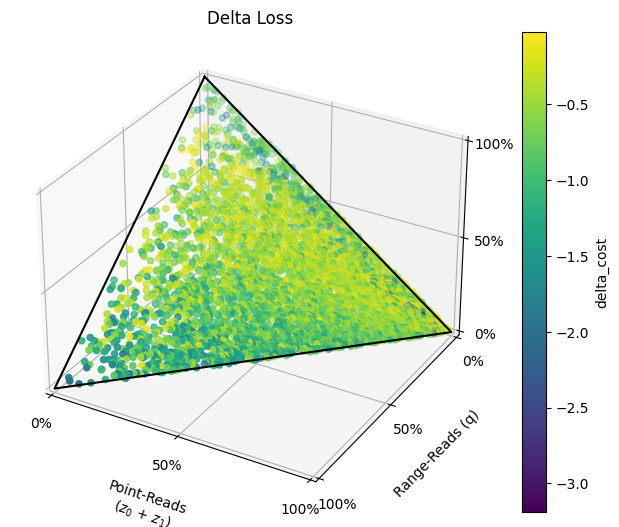

In [32]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='delta_cost')
ax.set_title('Delta Loss')
plt.show()

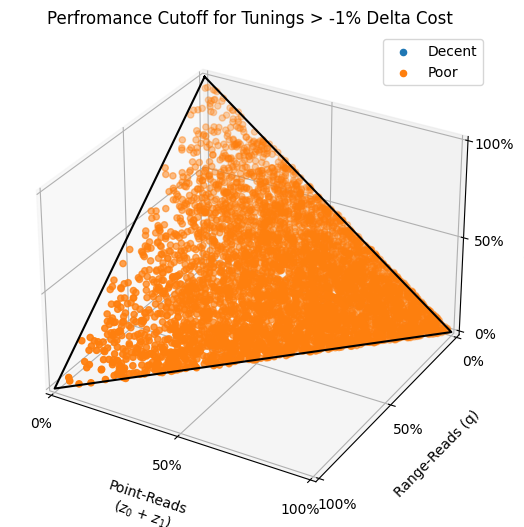

In [33]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

cutoff = (-0.01)
groupa = table[table['delta_cost'] > cutoff]
groupb = table[table['delta_cost'] < cutoff]
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='Decent')
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Poor')
ax.set_title(f'Perfromance Cutoff for Tunings > {cutoff:.0%} Delta Cost')
ax.legend()
plt.show()